# Data Cleaning

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
df_a = pd.read_csv('/Users/jonathanbugg/Desktop/lin_reg_proj/data/properties_2016.csv')
df_ab = pd.read_csv('/Users/jonathanbugg/Desktop/lin_reg_proj/data/train_2016_v2.csv')
df_b = pd.read_csv('/Users/jonathanbugg/Desktop/lin_reg_proj/data/properties_2017.csv')
df_bb = pd.read_csv('/Users/jonathanbugg/Desktop/lin_reg_proj/data/train_2017.csv')

/Users/jonathanbugg/Desktop/crypto_portfolio_opt/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (22,32,34,49,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/jonathanbugg/Desktop/crypto_portfolio_opt/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Step 0: Basic Data Preprocessing

In [47]:
print(f'FIPS Coverage: {df_a.censustractandblock.notna().sum()/len(df_a):.3f}')

# Drop Records w/o FIPS values
df_a = df_a[df_a.censustractandblock.notna()] 

# Recode Features with Boolean Values
bool_cols = ['hashottuborspa','fireplaceflag'] 

df_a.loc[:,bool_cols] = (df_a.loc[:,bool_cols] == True).astype(int)
    
# Code Zeros for "If Any" Features
if_any_cols = ['fireplacecnt','poolcnt']

df_a.loc[:, if_any_cols] = df_a.loc[:, if_any_cols].fillna(0) 

# Dropping columns which won't be usable in prediction
non_actionable_cols = [
    # Geographic
    'latitude',
    'longitude',
    'rawcensustractandblock', # Duplicative w/ Processed Values
    'regionidzip',
    'regionidcounty' # Duplicative w/ FIP
]

actionable_cols = [i for i in df_a.columns if i not in non_actionable_cols]

df_a = df_a.loc[:, actionable_cols]

FIPS Coverage: 0.975


# Step 1: Data Missingness

Drop Columns with >= 40% missingness (per https://www.sciencedirect.com/science/article/pii/S0895435618308710#:~:text=Statistical%20guidance%20articles%20have%20stated,18%5D%2C%20%5B19%5D.)

In [48]:
df_a_non_drop = pd.merge(df_a, df_ab, how='inner', on='parcelid')

# Columns by Null Records
print(df_a.isna().sum().sort_values()/len(df_a))

keep_cols = df_a.isna().sum().sort_values()/len(df_a) < .6
df_a = df_a.loc[:, keep_cols]

print(df_a.isna().sum().sort_values()/len(df_a))

df_non_imp = pd.merge(df_a, df_ab, how='inner', on='parcelid')

parcelid                        0.000000e+00
assessmentyear                  0.000000e+00
fireplaceflag                   0.000000e+00
propertylandusetypeid           0.000000e+00
poolcnt                         0.000000e+00
hashottuborspa                  0.000000e+00
fireplacecnt                    0.000000e+00
fips                            0.000000e+00
censustractandblock             0.000000e+00
bathroomcnt                     0.000000e+00
bedroomcnt                      0.000000e+00
roomcnt                         3.436319e-07
propertycountylandusecode       4.810846e-06
taxvaluedollarcnt               1.539814e-03
structuretaxvaluedollarcnt      3.839055e-03
taxamount                       4.558620e-03
landtaxvaluedollarcnt           9.674268e-03
calculatedfinishedsquarefeet    1.100962e-02
yearbuilt                       1.233432e-02
regionidcity                    1.611187e-02
calculatedbathnbr               2.237387e-02
fullbathcnt                     2.237387e-02
lotsizesqu

## Imputation of Continuous Variables

In [49]:
# Fill Continuous Columns with Median Values
continuous_cols = ['roomcnt','taxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt','calculatedfinishedsquarefeet','yearbuilt','landtaxvaluedollarcnt','calculatedbathnbr','lotsizesquarefeet','finishedsquarefeet12', 'unitcnt','fullbathcnt','buildingqualitytypeid']
categorical_cols = ['heatingorsystemtypeid','regionidcity', 'propertycountylandusecode','propertylandusetypeid','fips']

# Tract-Level Imputation
df_a['census_tract'] = df_a.censustractandblock.astype('string').apply(lambda x: x[:11]) # Create Tract String
tract_medians = df_a.loc[:, ['census_tract'] + continuous_cols].groupby('census_tract').filter(lambda x: len(x) >= 30).groupby('census_tract').median() # Minmum 30 Records per tract

# County Level Imputaiton
county_medians = df_a.loc[:, ['fips'] + continuous_cols].groupby('fips').median()

# Append Imputations to Dataframe
df_a_combined = pd.merge(pd.merge(df_a, tract_medians,'left', ['census_tract','census_tract'], suffixes = (None, '_tract')), county_medians, 'left', ['fips', 'fips'], suffixes = (None, '_county'))

for i in continuous_cols:
    
    state_median = df_a.loc[:,i].median()
    df_a.loc[:,i] = df_a.loc[:,i].fillna(df_a_combined.loc[:,f'{i}_tract'])  # Tract Level Imputaiton
    df_a.loc[:,i] = df_a.loc[:,i].fillna(df_a_combined.loc[:,f'{i}_county']) # County Level Imputation for Null-Valued Tracts
    df_a.loc[:,i] = df_a.loc[:,i].fillna(state_median)                       # State-Level Imputation for Null-Valued Counties
    
df_a.isna().sum().sort_values()/len(df_a)

parcelid                        0.000000
taxamount                       0.000000
landtaxvaluedollarcnt           0.000000
assessmentyear                  0.000000
taxvaluedollarcnt               0.000000
structuretaxvaluedollarcnt      0.000000
fireplaceflag                   0.000000
yearbuilt                       0.000000
unitcnt                         0.000000
roomcnt                         0.000000
propertylandusetypeid           0.000000
censustractandblock             0.000000
poolcnt                         0.000000
census_tract                    0.000000
hashottuborspa                  0.000000
fullbathcnt                     0.000000
fireplacecnt                    0.000000
fips                            0.000000
finishedsquarefeet12            0.000000
calculatedfinishedsquarefeet    0.000000
calculatedbathnbr               0.000000
buildingqualitytypeid           0.000000
bedroomcnt                      0.000000
bathroomcnt                     0.000000
lotsizesquarefee

In [ ]:
# Columns by Null Records
df_b = df_b[df_b.censustractandblock.notna()] 

df_b['census_tract'] = df_b.censustractandblock.astype('string').apply(lambda x: x[:11]) # Create Tract String
keep_cols = [i for i in df_b.columns if i in df_a.columns] + categorical_cols
df_b = df_b.loc[:, keep_cols]

# Recode Features with Boolean Values
df_b.loc[:,bool_cols] = (df_b.loc[:,bool_cols] == True).astype(int)
    
# Code Zeros for "If Any" Features
df_b.loc[:, if_any_cols] = df_b.loc[:, if_any_cols].fillna(0) 

# # Append Median Imputations to Dataframe
df_b_combined = pd.merge(pd.merge(df_b, tract_medians,'left', ['census_tract','census_tract'], suffixes = (None, '_tract')), county_medians, 'left', ['fips', 'fips'], suffixes = (None, '_county'))

# # Apply Median Imputations
for i in [i for i in continuous_cols if i in df_a.columns]:
    
    state_median = df_a.loc[:,i].median()
    df_b.loc[:,i] = df_b.loc[:,i].fillna(df_b_combined.loc[:,f'{i}_tract'])  # Tract Level Imputaiton
    df_b.loc[:,i] = df_b.loc[:,i].fillna(df_b_combined.loc[:,f'{i}_county']) # County Level Imputation for Null-Valued Tracts
    df_b.loc[:,i] = df_b.loc[:,i].fillna(state_median) 
    
df_b.isna().sum().sort_values()/len(df_b)

# Step 2: Examining Multicollinearity 

/var/folders/gp/0bstcdf92msf4b130ztx6zs00000gn/T/ipykernel_60217/1665663388.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df_non_imp.corr(), dtype=np.bool))


Text(0.5, 1.0, 'Triangle Correlation Heatmap')

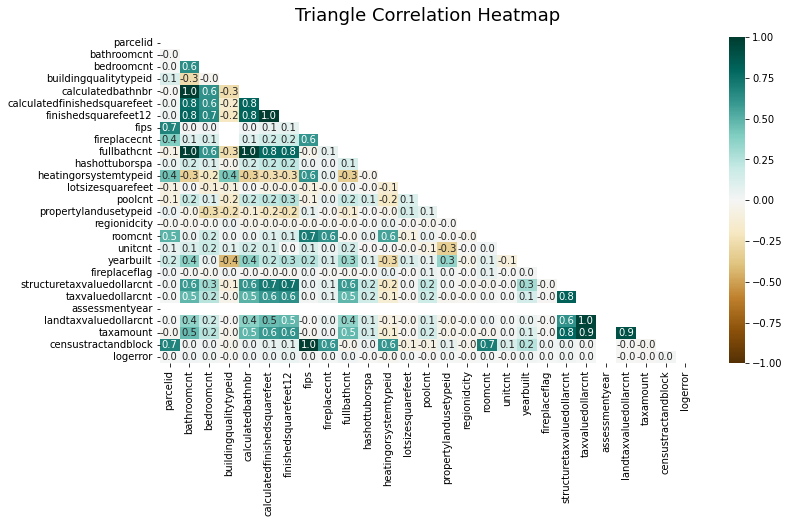

In [ ]:
np.triu(np.ones_like(df_non_imp.corr()))
plt.figure(figsize=(12, 6))
mask = np.triu(np.ones_like(df_non_imp.corr(), dtype=np.bool))
heatmap = sns.heatmap(df_non_imp.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG', fmt = '.1f')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

In [ ]:
df_a_non_drop[['calculatedbathnbr','bathroomcnt', 'fullbathcnt', 'threequarterbathnbr']].corr()

,calculatedbathnbr,bathroomcnt,fullbathcnt,threequarterbathnbr
calculatedbathnbr,1.000000,1.000000,0.984156,0.261072
bathroomcnt,1.000000,1.000000,0.984156,0.261072
fullbathcnt,0.984156,0.984156,1.000000,0.207773
threequarterbathnbr,0.261072,0.261072,0.207773,1.000000


In [ ]:
numeric_cols = []
for column in df_a_non_drop.columns:
    if 'squarefeet' in column or 'sqft' in column:
        numeric_cols.append(column)

sqft_corr_df = df_a_non_drop[numeric_cols].corr()
sqft_corr_df

,basementsqft,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,garagetotalsqft,lotsizesquarefeet,yardbuildingsqft17,yardbuildingsqft26
basementsqft,1.000000,0.130140,0.341610,0.341610,NaN,NaN,-0.031274,NaN,0.277500,-0.144900,0.017574,-0.329200
finishedfloor1squarefeet,0.130140,1.000000,0.703525,0.703593,NaN,0.635206,0.980167,NaN,0.603822,0.353340,0.369183,0.271345
calculatedfinishedsquarefeet,0.341610,0.703525,1.000000,1.000000,1.000000,1.000000,0.689781,1.00000,0.604778,-0.048698,0.339618,0.282325
finishedsquarefeet12,0.341610,0.703593,1.000000,1.000000,NaN,NaN,0.689842,NaN,0.626487,-0.046621,0.339642,0.284689
finishedsquarefeet13,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,0.295968,NaN,NaN
finishedsquarefeet15,NaN,0.635206,1.000000,NaN,NaN,1.000000,0.635206,NaN,NaN,0.125479,1.000000,NaN
finishedsquarefeet50,-0.031274,0.980167,0.689781,0.689842,NaN,0.635206,1.000000,NaN,0.587307,0.351935,0.356357,0.343029
finishedsquarefeet6,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,1.00000,NaN,0.158290,NaN,NaN
garagetotalsqft,0.277500,0.603822,0.604778,0.626487,NaN,NaN,0.587307,NaN,1.000000,0.244783,0.369510,0.339119
lotsizesquarefeet,-0.144900,0.353340,-0.048698,-0.046621,0.295968,0.125479,0.351935,0.15829,0.244783,1.000000,0.173286,0.393110


In [ ]:
numeric_cols = []
for column in df_a_non_drop.columns:
    if 'bath' in column:
        numeric_cols.append(column)

bed_bath_corr = df_a_non_drop[numeric_cols].corr()
bed_bath_corr

,bathroomcnt,calculatedbathnbr,fullbathcnt,threequarterbathnbr
bathroomcnt,1.000000,1.000000,0.984156,0.261072
calculatedbathnbr,1.000000,1.000000,0.984156,0.261072
fullbathcnt,0.984156,0.984156,1.000000,0.207773
threequarterbathnbr,0.261072,0.261072,0.207773,1.000000


In [ ]:
numeric_cols = []
for column in df_a_non_drop.columns:
    if 'tax' in column:
        numeric_cols.append(column)

tax_corr = df_a_non_drop[numeric_cols].corr()
tax_corr

,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear
structuretaxvaluedollarcnt,1.000000,0.825880,0.623525,0.794902,0.069302
taxvaluedollarcnt,0.825880,1.000000,0.955568,0.949597,0.083480
landtaxvaluedollarcnt,0.623525,0.955568,1.000000,0.903020,0.076410
taxamount,0.794902,0.949597,0.903020,1.000000,0.072436
taxdelinquencyyear,0.069302,0.083480,0.076410,0.072436,1.000000


In [ ]:
subset = df_a_non_drop[numeric_cols]
subset['sum'] = subset.structuretaxvaluedollarcnt + subset.landtaxvaluedollarcnt
subset

/var/folders/gp/0bstcdf92msf4b130ztx6zs00000gn/T/ipykernel_60217/1448476909.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['sum'] = subset.structuretaxvaluedollarcnt + subset.landtaxvaluedollarcnt


,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,sum
0,115087.0,191811.0,76724.0,2015.06,NaN,NaN,191811.0
1,143809.0,239679.0,95870.0,2581.30,NaN,NaN,239679.0
2,33619.0,47853.0,14234.0,591.64,NaN,NaN,47853.0
3,45609.0,62914.0,17305.0,682.78,NaN,NaN,62914.0
4,277000.0,554000.0,277000.0,5886.92,NaN,NaN,554000.0
...,...,...,...,...,...,...,...
89665,223410.0,490808.0,267398.0,5005.48,NaN,NaN,490808.0
89666,276843.0,433819.0,156976.0,5179.82,NaN,NaN,433819.0
89667,388582.0,596082.0,207500.0,7335.81,NaN,NaN,596082.0
89668,86209.0,178408.0,92199.0,2441.74,NaN,NaN,178408.0


In [ ]:
# Filter Down to Training Records; Drop  Zoning Code (Cardinality Too high), features with high correlation (see additional analysis)
df_a = df_a.merge(df_ab, 'inner', 'parcelid')
df_a = df_a.loc[:, [i for i in df_a.columns if i not in [
    'propertyzoningdesc',
    'taxvaluedollarcnt','taxamount', 
    'finishedsquarefeet6','finishedsquarefeet12','finishedsquarefeet13','finishedsquarefeet15','finishedsquarefeet50',
    'bathroomcnt', 'fullbathcnt', 'threequarterbathnbr']
]]
df_a.isna().sum().sort_values()/len(df_a)

parcelid                        0.000000
census_tract                    0.000000
censustractandblock             0.000000
landtaxvaluedollarcnt           0.000000
assessmentyear                  0.000000
structuretaxvaluedollarcnt      0.000000
fireplaceflag                   0.000000
yearbuilt                       0.000000
unitcnt                         0.000000
roomcnt                         0.000000
logerror                        0.000000
propertylandusetypeid           0.000000
poolcnt                         0.000000
lotsizesquarefeet               0.000000
hashottuborspa                  0.000000
fireplacecnt                    0.000000
fips                            0.000000
calculatedfinishedsquarefeet    0.000000
calculatedbathnbr               0.000000
buildingqualitytypeid           0.000000
bedroomcnt                      0.000000
transactiondate                 0.000000
propertycountylandusecode       0.000011
regionidcity                    0.018981
heatingorsystemt

# Step 3: One Hot encoding

In [ ]:
# One-Hot Encode Categorical Features
categorical_cols = ['heatingorsystemtypeid','regionidcity', 'propertycountylandusecode','propertylandusetypeid','fips']
df_a.loc[:,categorical_cols] = df_a.loc[:,categorical_cols].astype('object')
df_a = df_a.merge(pd.get_dummies(df_a.loc[:, categorical_cols]), left_index = True, right_index = True)

# #Drop Redundant Columns
drop_cols = categorical_cols + [f'{i}_x' for i in categorical_cols] + [f'{i}_y' for i in categorical_cols]
df_a = df_a.loc[:,[i for i in df_a.columns if i not in drop_cols]]

In [ ]:
# Filter Down to Training Records; Drop  Zoning Code (Cardinality Too high)
df_b = df_b.merge(df_bb, 'inner', 'parcelid')
df_b = df_b.loc[:, [i for i in df_b.columns if i not in ['propertyzoningdesc']]]
df_b.isna().sum().sort_values()/len(df_a)

parcelid                        0.000000
logerror                        0.000000
transactiondate                 0.000000
longitude                       0.000379
bathroomcnt                     0.000379
bedroomcnt                      0.000379
assessmentyear                  0.000379
roomcnt                         0.000379
regionidcounty                  0.000379
rawcensustractandblock          0.000379
propertylandusetypeid           0.000379
propertycountylandusecode       0.000379
latitude                        0.000379
fips                            0.000379
taxvaluedollarcnt               0.000390
landtaxvaluedollarcnt           0.000401
taxamount                       0.000435
regionidzip                     0.000937
structuretaxvaluedollarcnt      0.001662
calculatedfinishedsquarefeet    0.002621
censustractandblock             0.003134
yearbuilt                       0.003390
calculatedbathnbr               0.007249
fullbathcnt                     0.007249
regionidcity    

In [ ]:
# One-Hot Encode Categorical Features
df_b.loc[:,categorical_cols] = df_b.loc[:,categorical_cols].astype('object')
df_b = df_b.merge(pd.get_dummies(df_b.loc[:, categorical_cols]), left_index = True, right_index = True)

# Drop Redundant Columns
df_b = df_b.loc[:,[i for i in df_b.columns if i in df_a.columns]]

# Filter Down to shared columns
shared_cols = [i for i in df_a.columns if i in df_b.columns]

df_a = df_a.loc[:, shared_cols]
df_b = df_b.loc[:, shared_cols]

In [ ]:
# Export Data
df_a.to_csv('2016_cleaned_v2.csv', index = False)
df_b.to_csv('2017_cleaned_v2.csv', index = False)